In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt

In [4]:
LOGS = ["matsumoto-nagano-100318.log", "nagano-matsumoto-100318.log"]

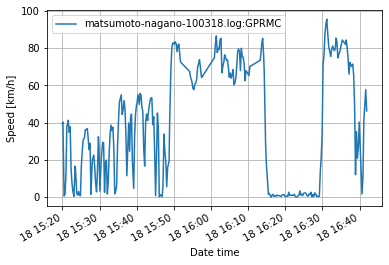

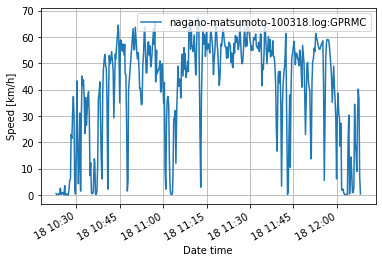

In [5]:
# q5
''' 課題10の5
GPS受信器から出力されるデータから速度を抽出します。
 [km/h] に変換して「横軸：時間、縦軸：速度」のプロットを作ります

利用方法：
LOGSにNMEAフォーマットのGPRMCデータを含むログファイルを指定。
python3 q05.py

注意点：
ここではGPRMCのデータだけを抽出します。
入力データはUTCと思われます。JSTにしてプロットします。
事前にpython3 -m pip install matplotlibを行う必要があります。
'''

datetimes_jst = {}
speeds = {}
for logfile in LOGS:
    datetimes_jst[logfile] = []
    speeds[logfile] = []
    plt.figure()
    with open(logfile) as f:
        for line in f:
            if "$GPRMC" in line:
                gprmc = line.split(',')
                datetime_utc = datetime.datetime.strptime(
                    gprmc[9] + gprmc[1], '%d%m%y%H%M%S')
                datetime_jst = datetime_utc + datetime.timedelta(hours=9)
                speed = float(gprmc[7])*1.852
                datetimes_jst[logfile].append(datetime_jst)
                speeds[logfile].append(speed)
    plt.plot(datetimes_jst[logfile], speeds[logfile], label=logfile+":GPRMC")
    plt.grid()
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.xlabel("Date time")
    plt.ylabel("Speed [km/h]")
plt.show()